# Numerics of Machine Learning
# Exercise Sheet No. 12 — Second-Order Optimization (Solution)

---
University of Tübingen, Winter Term 2022/23
&copy; N. Bosch, J. Grosse, P. Hennig, A. Kristiadi, M. Pförtner, J. Schmidt, F. Schneider, L. Tatzel, J. Wenger, 2022 CC BY-NC-SA 3.0

---

PLEASE FILL OUT FOR ALL TEAM MEMBERS:
- Last name, first name, Matrikelnr.
- Last name, first name, Matrikelnr.

The homework must be submitted as a `.pdf` on ILIAS. We do not grade `.ipynb` submissions.

<img src="Exercise_12_Screenshot.PNG" alt="Drawing" style="width: 750px;"/>

# EXAMple Question

Let 
$
q(\theta) 
= \mathcal{L}(\theta^{(k)}) 
+ (\theta - \theta^{(k)})^T g 
+ \frac{1}{2}(\theta - \theta^{(k)})^T H (\theta - \theta^{(k)})
$, with 
gradient $g := \nabla \mathcal{L}(\theta^{(k)})$ and 
Hessian $H := \nabla^2 \mathcal{L}(\theta^{(k)})$.

**Exercise (a):** It holds

\begin{align}
h(\tau) 
&:= q(\theta^{(k)} + \tau d) \\
&= \mathcal{L}(\theta^{(k)}) 
+ (\theta^{(k)} + \tau d - \theta^{(k)})^T g 
+ \frac{1}{2}(\theta^{(k)} + \tau d - \theta^{(k)})^T H (\theta^{(k)} + \tau d - \theta^{(k)}) \\
&= \mathcal{L}(\theta^{(k)}) 
+ \tau d^T g 
+ \frac{1}{2} \tau^2 d^T H d.
\end{align}

Thus, we obtain the *directional* slope $h'(\tau) = d^T g + \tau d^T H d$ and curvature $h''(\tau) = d^T H d$.

**Exercise (b):** For a normalized eigenvector $e$ (i.e. $\Vert e \Vert = 1$) of the Hessian (with eigenvalue $\lambda$), we obtain the directional curvature $h''(\tau) = e^T H e$, according to Exercise a. It follows

\begin{equation}
h''(\tau) = e^T H e = e^T \lambda e = \lambda e^T e = \lambda \Vert e \Vert^2 = \lambda.
\end{equation}

# Coding Exercise

**Overview:** 
This week's coding exercise is concerned with the Hessian-free method and the role of damping in stochastic second-order optimization. There are three parts:
1. First, we will implement a basic version of the Hessian-free optimizer in PyTorch. If you want to know more about this optimizer, you can find the paper [here](https://www.cs.toronto.edu/~jmartens/docs/Deep_HessianFree.pdf). 
2. Next, we will apply this optimizer to a small neural network. 
3. Finally, we will investigate the relation between damping and its dependence on the mini-batch size. 

In [1]:
import copy
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Make deterministic
random_seed = 0
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # matplotlib bugfix

## 1. Hessian-free optimizer in PyTorch

Below, we will implement a second-order method that was discussed in the lecture: the Hessian-free (HF) optimizer. This optimizer uses the method of conjugate gradients to approximate the Newton step. Note that a lot of functionality (e.g. the `cg`-method, the GGN-vector product, and functions for converting the model's parameters to a vector and vice versa) is already implemented in `hf_utils.py`. 

**Your task:** Complete the missing bits of code below (marked with `TODO`).

In [3]:
from torch.nn.utils.convert_parameters import parameters_to_vector

from hf_utils import (
    cg,
    ggn_vector_product,
    vector_to_parameter_list,
    vector_to_trainparams,
)


class HessianFree(torch.optim.Optimizer):
    """This class implements a basic version of a Hessian-free optimizer in 
    Pytorch.
    """

    def __init__(
        self,
        params,
        damping=0.0,
        cg_maxiter=20,
        lr=1.0,
        verbose=False,
    ):
        """The constructor creates an instance of the `HessianFree` optimizer.
        
        Args:
            params: An iterable of `torch.Tensor`s that represents the 
                network's parameters.
            damping: A scalar multiple of the identity matrix is added to the
                curvature matrix when the cg-method is applied. This damping 
                parameter is kept constant.
            cg_max_iter: The maximum number of cg-iterations. 
            lr: The learning rate. The update step is scaled by this scalar. 
            verbose (bool): Print information during the computations.
        """

        # Check hyperparameters
        if damping < 0.0:
            raise ValueError(f"Invalid damping = {damping}")
        if cg_maxiter < 1:
            raise ValueError(f"Invalid cg_max_iter: {cg_max_iter}")
        if lr < 0.0 or lr > 1.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        
        # Call parent class constructor
        defaults = dict(damping=damping, cg_maxiter=cg_maxiter, lr=lr)
        super().__init__(params, defaults)

        # Only one parameter group is supported
        if len(self.param_groups) != 1:
            error_msg = "`HessianFree` does not support per-parameter options."
            raise ValueError(error_msg)

        self.verbose = verbose
        self._group = self.param_groups[0]
        self._params = self._group["params"]

        # All computations are performed in the subspace of trainable parameters
        self._params_list = [p for p in self._params if p.requires_grad]
        self.device = self._params_list[0].device
        
        # Print info 
        if self.verbose:
            num_params = sum(p.numel() for p in self._params_list)
            print("Number of trainable parameters: ", num_params)
            print("Device = ", self.device)
    
    
    @staticmethod
    def _Gv(loss, outputs, params_list, vec):
        """Return the GGN-vector product with the vector `vec`."""
        
        ### TODO: Implement the GGN-vector product. 
        
        ### SOLUTION
        vec_list = vector_to_parameter_list(vec, params_list)
        Gv = ggn_vector_product(loss, outputs, params_list, vec_list)
        return parameters_to_vector(Gv).detach()
    
    
    def step(self, forward):
        """Perform an update step.
        
        Args:
            forward: This function returns a `(loss, outputs)`-tuple,
                where `loss` is the target function value. Here is a pseudo-code
                example of the training loop:
                ```
                for step_idx in range(num_steps):
                    inputs, targets = get_minibatch_data()
                    
                    def forward():
                        outputs = model(inputs)
                        loss = loss_function(outputs, targets)
                        return loss, outputs
                    
                    opt.step(forward=forward)
                ```
        """
        
        if self.verbose:
            print(f"\nComputing HF update step...")
        
        
        # ----------------------------------------------------------------------
        # Set up the linear system
        # ----------------------------------------------------------------------

        # Evaluate the loss
        loss, outputs = forward()
        init_loss = loss.item()

        # Evaluate the gradient
        grad = torch.autograd.grad(
            loss, self._params_list, create_graph=True, retain_graph=True
        )
        grad = parameters_to_vector(grad).detach()
        
        # Matrix-vector products with the curvature matrix
        def mvp(x):
            return self._Gv(loss, outputs, self._params_list, x)
        
        
        # ----------------------------------------------------------------------
        # Apply cg
        # ----------------------------------------------------------------------
        damping = self._group["damping"]
        cg_maxiter = self._group["cg_maxiter"]

        if self.verbose:
            print(f"  Running cg...")
        
        
        ### TODO: Apply cg (with at most `cg_maxiter` iterations) to the damped (!)
        ### linear system.
            
        ### SOLUTION
        step_vec = cg(
            A=lambda x: mvp(x) + damping * x,  # Add damping
            b=-grad,
            maxiter=cg_maxiter,
        )

        
        # ----------------------------------------------------------------------
        # Parameter update
        # ----------------------------------------------------------------------
        lr = self._group["lr"]
        
        ### TODO: Scale the Newton step with the learning rate, update the parameters
        
        ### SOLUTION
        params_vec = parameters_to_vector(self._params_list).detach()
        new_params_vec = params_vec + lr * step_vec
        vector_to_trainparams(new_params_vec, self._params)

        # Print initial and final loss
        final_loss = forward()[0].item()
        if self.verbose:
            msg = f"  Initial loss = {init_loss:.6f} --> "
            msg += f"final loss = {final_loss:.6f}"
            print(msg)
            
        return 

## 2. Apply HF to a simple test problem

Before we can apply our optimizer, we have to define a test problem. We will use a simple neural network on MNIST data.

### 2.1 Preparations

In [4]:
# Download data set to this folder
data_dir = os.path.join(os.getcwd(), "data")

# Normalize data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
])

# Training and test data
train_data = MNIST(data_dir, train=True, download=True, transform=transform)
test_data = MNIST(data_dir, train=False, download=True, transform=transform)

# Data loaders for training and test data
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True, 
        drop_last=True
    )

def get_test_loader(batch_size):
    return torch.utils.data.DataLoader(
        test_data, 
        batch_size=batch_size, 
        shuffle=False
    )

In [5]:
# Set up model
def get_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
    )

In [6]:
# Loss-function
loss_func = torch.nn.CrossEntropyLoss(reduction="mean")
loss_func_no_reduction = torch.nn.CrossEntropyLoss(reduction="none")

In [7]:
def eval_mb_metrics(model, inputs, targets):
    """Compute the loss and accuracy on the mini-batch defined by `inputs` 
    and `targets`.
    """
    
    # Put model into evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        # Forward pass, compute loss and accuracy
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        predictions = torch.argmax(outputs, 1)
        acc = (predictions == targets).sum() / len(targets)
        return loss.item(), acc.item()
    

def eval_test_metrics(model, batchsize_test):
    """Compute the loss and accuracy on the test set."""
    
    # Put model into evaluation mode
    model.eval()
    
    loss = 0.0
    correct_counter = 0
    data_counter = 0
    
    with torch.no_grad():
        for inputs, targets in get_test_loader(batchsize_test):
            
            # Forward pass, aggregate loss and correct predictions
            outputs = model(inputs)
            loss += loss_func_no_reduction(outputs, targets).sum().item()
            predictions = torch.argmax(outputs, 1) 
            correct_counter += (predictions == targets).sum().item()
            data_counter += len(targets)
    
    loss /= data_counter
    acc = correct_counter / data_counter
    
    return loss, acc

### 2.2. Run HF

Let's apply the optimizer to our test problem. We have to perform multiple training runs with the HF-optimizer in the next part of the tutorial, so it makes sense to implement a reusable `run_hf`-function. This function runs the Hessian-free optimizer for a given number of steps `num_steps`. It contains a training loop and stores and returns the training metrics (mini-batch loss/accuracy and test loss/accuracy).

**Your task:** Complete the missing bits of code below (marked with `TODO`). 

In [8]:
def log_mb_metrics(model, inputs, targets, step, results_dict):
    """Compute the mini-batch loss and accuracy in step `step` and 
    put the results into `results_dict`.
    """
    loss, acc = eval_mb_metrics(model, inputs, targets)
    
    # Store results
    results_dict["step"].append(step)
    results_dict["loss"].append(loss)
    results_dict["acc"].append(acc)

    
def log_test_metrics(model, batchsize_test, step, results_dict):
    """Compute the test loss and accuracy in step `step` and 
    put the results into `results_dict`.
    """
    loss, acc = eval_test_metrics(model, batchsize_test)
    
    # Store results
    results_dict["step"].append(step)
    results_dict["loss"].append(loss)
    results_dict["acc"].append(acc)


def run_hf(
    model,
    opt,
    batchsize_train,
    batchsize_test,
    num_steps,
    log_test_metrics_every
):
    """Run the Hessian-free optimizer `opt` for `num_steps` steps. The test
    loss and accuracy are evaluated every `log_test_metrics_every` steps.
    """
    
    # Track these quantities
    mb_metrics_before = {"step": [], "loss": [], "acc": []}
    mb_metrics_after = {"step": [], "loss": [], "acc": []}
    test_metrics_after = {"step": [], "loss": [], "acc": []}
        
    # Training loop
    train_loader = get_train_loader(batchsize_train)
    step = 0
    while True:
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            
            # Log before
            log_mb_metrics(model, inputs, targets, step, mb_metrics_before)
                
            # Put model into training mode
            model.train()
            
            ### TODO: Compute and apply the HF step
            
            ### SOLUTION
        
            # Define forward-function, perform HF step
            def forward():
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                return loss, outputs
                
            opt.step(forward)
            
            # Log after
            log_mb_metrics(model, inputs, targets, step, mb_metrics_after)
            if step % log_test_metrics_every == 0:
                log_test_metrics(model, batchsize_test, step, test_metrics_after)
            
            # Increment step counter
            step += 1
            
            # Break from training loop after `num_steps` steps
            if step >= num_steps:
                break
        if step >= num_steps:
            break
    
    # Return training metrics
    return mb_metrics_before, mb_metrics_after, test_metrics_after

In [9]:
# Get model, optimizer, data
model = get_model()
opt = HessianFree(
    model.parameters(),
    damping=1.0,
    cg_maxiter=20,
    lr=1.0,
    verbose=False
)

# Apply the optimizer to the test problem
metrics = run_hf(
    model, 
    opt, 
    batchsize_train=100, 
    batchsize_test=1000,
    num_steps=20, 
    log_test_metrics_every=1
)
mb_metrics_before, mb_metrics_after, test_metrics_after = metrics

**Your task:** Visualize the three metrics returned by `run_hf` in two subplots (one containing the losses, the other one the accuracies). Is the per-step progress on the mini-batch always reflected in similar progress on the test set? If not, do you have an explanation for this observation?

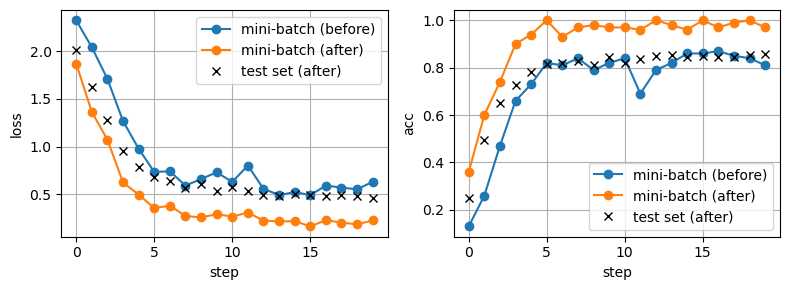

In [10]:
### TODO: Visualization

### SOLUTION
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

for ax_idx, metric in enumerate(["loss", "acc"]):
    ax = axs[ax_idx]
    
    # Plot loss/acc on mini-batch and test set
    ax.plot(mb_metrics_before["step"], mb_metrics_before[metric], "-o", label="mini-batch (before)")
    ax.plot(mb_metrics_after["step"], mb_metrics_after[metric], "-o", label="mini-batch (after)")
    ax.plot(test_metrics_after["step"], test_metrics_after[metric], "kx", label="test set (after)")
    
    # General plot settings
    ax.set_xlabel("step")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

**Your answer:** TODO

**My answer:** 
- In the beginning, the progress in the mini-batch metrics is also reflected in the test metrics (to a similar but slightly smaller extent). 
- This changes after a few steps: The optimizer still makes progress on the mini-batch. But this is barely reflected in the test metrics. This is due to *overfitting to the mini-batch*.
- Depending on how *reliable* our stochastic quadratic model is, we have to control the length of the parameter updates (e.g. by adapting the damping parameter). 

## 3. Batch size and damping

The Hessian-free optimizer uses a stochastic estimate of the gradient and the curvature. The noise on these estimates depends on the size of the mini batch: The more data is used, the more accurate the estimates. If our estimates are very noisy, we might want to restrict the optimizer to smaller updates, i.e. use larger damping. So, the optimal damping seems to depend on the mini-batch size. Let's investigate this dependency in more detail. 

First, we define a set of five different batch sizes (`50`, `100`, `200`, `400` and `1000`) and a set of four damping values (`5e-2`, `1e-1`, `5e-1`, and `1.0`). For each combination of batch size and damping, we run the HF-optimizer and evaluate the *best* test loss and test accuracy that was achieved during the HF-run. For a fair comparison between multiple runs with different batch sizes, we choose the number of steps such that `batch_size * num_steps` is constant for all runs (see `batch_size_to_steps` below).

**Your task:** Complete the missing bits of code below (marked with `TODO`).

In [11]:
# Get a fresh model
model_orig = get_model()

# Key = batch size, 
# Value = number of steps
batch_size_to_steps = {
    50: 40,
    100: 20,
    200: 10,
    400: 5,
    1000: 2,
}
dampings = [5e-2, 1e-1, 5e-1, 1.0]

# Best test loss/acc for all batch size damping combinations
best_test_loss = torch.empty(len(batch_size_to_steps), len(dampings))
best_test_acc = torch.empty(len(batch_size_to_steps), len(dampings))

# Go through all combinations of batch size and damping
for bs_idx, (batch_size, num_steps) in enumerate(batch_size_to_steps.items()):    
    for damping_idx, damping in enumerate(dampings):
        
        # Set up problem (copy model!!)
        model = copy.deepcopy(model_orig)
        opt = HessianFree(
            model.parameters(),
            damping=damping,
            cg_maxiter=20,
            lr=1.0,
            verbose=False
        )
        
        # Print info
        log_every=int(math.ceil(num_steps/10))
        info_msg = f"batch_size = {batch_size}, num_steps = {num_steps}, "
        info_msg += f"damping = {damping}, log_every = {log_every}"
        print(info_msg)
        
        ### TODO: Run HF, store the best test loss/acc achieved within the given 
        ### number of steps in `best_test_loss`/`best_test_acc`
        
        ### SOLUTION
        metrics = run_hf(
            model, 
            opt, 
            batchsize_train=batch_size, 
            batchsize_test=1000,
            num_steps=num_steps, 
            log_test_metrics_every=log_every
        )
        _, _, test_metrics_after = metrics
        best_test_loss[bs_idx, damping_idx] = min(test_metrics_after["loss"])
        best_test_acc[bs_idx, damping_idx] = max(test_metrics_after["acc"])

batch_size = 50, num_steps = 40, damping = 0.05, log_every = 4
batch_size = 50, num_steps = 40, damping = 0.1, log_every = 4
batch_size = 50, num_steps = 40, damping = 0.5, log_every = 4
batch_size = 50, num_steps = 40, damping = 1.0, log_every = 4
batch_size = 100, num_steps = 20, damping = 0.05, log_every = 2
batch_size = 100, num_steps = 20, damping = 0.1, log_every = 2
batch_size = 100, num_steps = 20, damping = 0.5, log_every = 2
batch_size = 100, num_steps = 20, damping = 1.0, log_every = 2
batch_size = 200, num_steps = 10, damping = 0.05, log_every = 1
batch_size = 200, num_steps = 10, damping = 0.1, log_every = 1
batch_size = 200, num_steps = 10, damping = 0.5, log_every = 1
batch_size = 200, num_steps = 10, damping = 1.0, log_every = 1
batch_size = 400, num_steps = 5, damping = 0.05, log_every = 1
batch_size = 400, num_steps = 5, damping = 0.1, log_every = 1
batch_size = 400, num_steps = 5, damping = 0.5, log_every = 1
batch_size = 400, num_steps = 5, damping = 1.0, log_every 

**Your task:** Visualize the optimal damping (in terms of test loss and test accuracy) for each batch size. 

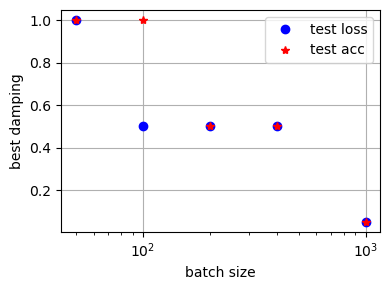

In [12]:
### TODO: Visualization

### SOLUTION
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for bs_idx, (batch_size, _) in enumerate(batch_size_to_steps.items()): 
    
    # Loss
    best_damping_idx = torch.argmin(best_test_loss[bs_idx, :])
    ax.plot(
        batch_size, 
        dampings[best_damping_idx], 
        'bo',
        label="test loss" if bs_idx==0 else None,
    )
    
    # Accuracy
    best_damping_idx = torch.argmax(best_test_acc[bs_idx, :])
    ax.plot(
        batch_size, 
        dampings[best_damping_idx], 
        'r*',
        label="test acc" if bs_idx==0 else None,
    )
    
    
# General plot settings
ax.set_xlabel("batch size")
ax.set_xscale("log")
ax.set_ylabel("best damping")
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

**Observations:** The observations confirm our hypothesis.

**Your task:** For each batch size, plot the best test loss and test accuracy (in two separate plots) achieved using the ideal damping. Write down your observations and possible explanations. 

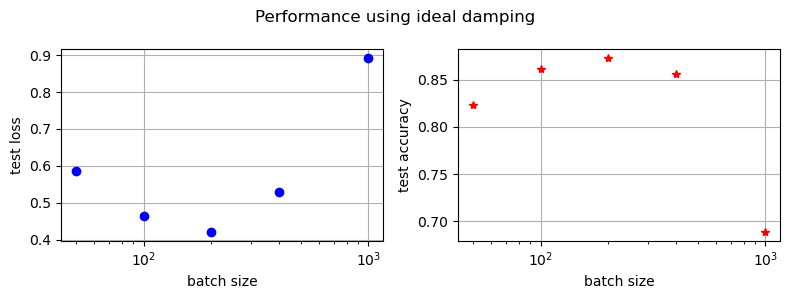

In [13]:
### TODO: Visualization

### SOLUTION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

for bs_idx, (batch_size, _) in enumerate(batch_size_to_steps.items()): 
    
    # Loss
    ax1.plot(batch_size, torch.min(best_test_loss[bs_idx, :]), 'bo')
    
    # Accuracy
    ax2.plot(batch_size, torch.max(best_test_acc[bs_idx, :]), 'r*')
    
# General plot settings
for ax in [ax1, ax2]:
    ax.set_xlabel("batch size")
    ax.set_xscale("log")
    ax.grid()
ax1.set_ylabel("test loss")
ax2.set_ylabel("test accuracy")

fig.suptitle("Performance using ideal damping")
fig.tight_layout()
plt.show()

**Your answer:** TODO

**My answer:**
- For the smaller batch sizes, the noise in the quadratic model seems to be the limiting factor.
- For the large batch sizes, the quadratics are more reliable, but we can only perform a few steps within the given "budget". 
- The most effective batch size seems to be between those two extremes: If we use appropriate damping, the quadratics are "reliable enough" and we can make a "decent" number of steps. 

**Criticism:** We should use multiple runs with different seeds, multiple initializations (`model_orig`), and multiple test problems for more robust statements. 


# Backup

In [14]:
# ----------------------------------------------------------------------
# Parameters as list vs. vector
# ----------------------------------------------------------------------

# Define HF-optimizer
model = get_model()
opt = HessianFree(
    model.parameters(),
    damping=1.0,
    cg_maxiter=20,
    lr=1.0,
    verbose=False
)

print("List representation")
params_list = opt._params_list
for p in params_list:
    print(f"  p.shape = {p.shape}; p.numel() = {p.numel()}")

print("\nVector representation")
params_vec = parameters_to_vector(params_list)
print(params_vec.shape)

List representation
  p.shape = torch.Size([10, 784]); p.numel() = 7840
  p.shape = torch.Size([10]); p.numel() = 10
  p.shape = torch.Size([10, 10]); p.numel() = 100
  p.shape = torch.Size([10]); p.numel() = 10

Vector representation
torch.Size([7960])


In [15]:
# ----------------------------------------------------------------------
# CG
# ----------------------------------------------------------------------
torch.manual_seed(0)

D = 3
A = torch.rand(D, D)
A = A.T @ A + 1e-1 * torch.eye(D)
x_solution = torch.rand(D)
b = A @ x_solution

# Check assumptions
print("A = \n", A)
A_eigvals = torch.linalg.eigh(A).eigenvalues
print("A eigenvalues: ", A_eigvals)
print("A positive definite?", torch.all(A_eigvals > 0))
print("A condition number: ", A_eigvals.max().item() / A_eigvals.min().item())
print("\nb = ", b)

# Apply CG
x_cg = cg(lambda v: A @ v, b, maxiter=10)
print("\nx_solution = ", x_solution)
print("x_cg       = ", x_cg)

A = 
 tensor([[0.6039, 0.8612, 0.3509],
        [0.8612, 1.5883, 0.6713],
        [0.3509, 0.6713, 0.7175]])
A eigenvalues:  tensor([0.1008, 0.3851, 2.4238])
A positive definite? tensor(True)
A condition number:  24.046939800132108

b =  tensor([0.8233, 1.3684, 0.7443])

x_solution =  tensor([0.6323, 0.3489, 0.4017])
x_cg       =  tensor([0.6323, 0.3489, 0.4017])
